In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math 
from patsy import dmatrices

from sklearn import tree 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz

import graphviz
from graphviz import Source

import joblib
from joblib import load, dump
import pickle
import json

from os.path import exists


In [2]:
# load datasets
df_leavetimes = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_leavetimes_DB_2018_CLEANED.csv')
df_trips = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_trips_DB_2018_CLEANED.csv')
df_vehicles = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_vehicles_DB_2018_CLEANED.csv')

In [3]:
# data for individual stops
df_leavetimes.head(5)

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDSTOPTIME_ARR/DEP,ACTUALSTOPTIME_ARR,ACTUALSTOPTIME_DEP,VEHICLEID
0,01-JAN-18 00:00:00,5972116,12,119,48030,48012,48012,2693211
1,01-JAN-18 00:00:00,5966674,12,119,54001,54023,54023,2693267
2,01-JAN-18 00:00:00,5959105,12,119,60001,59955,59955,2693263
3,01-JAN-18 00:00:00,5966888,12,119,58801,58771,58771,2693284
4,01-JAN-18 00:00:00,5965960,12,119,56401,56309,56323,2693209


In [4]:
# data for full trips
df_trips.head(5)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE
0,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,",2967409,",2.0,2.0
1,07-FEB-18 00:00:00,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,",2448968,",2.0,2.0
2,07-FEB-18 00:00:00,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,",3094242,",2.0,2.0
3,07-FEB-18 00:00:00,6253175,14,14_15,1,85383,81600,84682.0,81608.0,",2526331,",2.0,2.0
4,07-FEB-18 00:00:00,6248240,77A,77A_28,2,41648,37200,42019.0,37538.0,",2966500,",2.0,2.0


In [5]:
# data for vehicles
df_vehicles.head(5)

,DAYOFSERVICE,VEHICLEID,DISTANCE,MINUTES
0,23-NOV-18 00:00:00,3303848,286166,58849
1,23-NOV-18 00:00:00,3303847,259545,56828
2,28-FEB-18 00:00:00,2868329,103096,40967
3,28-FEB-18 00:00:00,2868330,147277,43599
4,28-FEB-18 00:00:00,2868331,224682,40447


In [6]:
print(df_leavetimes.shape, df_trips.shape, df_vehicles.shape)

(116949113, 8) (1893367, 12) (272611, 4)


In [7]:
# join trip data with stop data
df1 = pd.merge(df_leavetimes, df_trips, on=['DAYOFSERVICE','TRIPID'])

df1.head(5)

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDSTOPTIME_ARR/DEP,ACTUALSTOPTIME_ARR,ACTUALSTOPTIME_DEP,VEHICLEID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE
0,01-JAN-18 00:00:00,5972116,12,119,48030,48012,48012,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0
1,01-JAN-18 00:00:00,5972116,13,44,48079,48058,48058,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0
2,01-JAN-18 00:00:00,5972116,14,7603,48114,48071,48071,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0
3,01-JAN-18 00:00:00,5972116,15,45,48155,48089,48100,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0
4,01-JAN-18 00:00:00,5972116,16,46,48221,48137,48137,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0


In [8]:
df1.shape

(103448734, 18)

In [9]:
# check that stop departure times don't occur before the trip starts
df1[df1['ACTUALSTOPTIME_DEP'] < df1['ACTUALTIME_DEP']]

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDSTOPTIME_ARR/DEP,ACTUALSTOPTIME_ARR,ACTUALSTOPTIME_DEP,VEHICLEID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE
25151,01-JAN-18 00:00:00,5969584,4,127,65123,65121,65142,2868313,4,4_10,1,68364,64800,67894.0,65321.0,",1905606,1905606,",0.0,1.0
25152,01-JAN-18 00:00:00,5969584,5,112,65211,65186,65207,2868313,4,4_10,1,68364,64800,67894.0,65321.0,",1905606,1905606,",0.0,1.0
25153,01-JAN-18 00:00:00,5969584,6,113,65278,65262,65262,2868313,4,4_10,1,68364,64800,67894.0,65321.0,",1905606,1905606,",0.0,1.0
25154,01-JAN-18 00:00:00,5969584,7,114,65294,65274,65290,2868313,4,4_10,1,68364,64800,67894.0,65321.0,",1905606,1905606,",0.0,1.0
25160,01-JAN-18 00:00:00,5969584,3,7113,65021,65051,65073,2868313,4,4_10,1,68364,64800,67894.0,65321.0,",1905606,1905606,",0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103416362,31-DEC-18 00:00:00,8578213,34,4495,32516,32864,32880,3393875,15,15_19,1,34489,30600,34697.0,36923.0,",3362538,",0.0,12.0
103416363,31-DEC-18 00:00:00,8578213,54,1122,33507,33879,33879,3393875,15,15_19,1,34489,30600,34697.0,36923.0,",3362538,",0.0,12.0
103416365,31-DEC-18 00:00:00,8578213,14,1275,31328,31476,31489,3393875,15,15_19,1,34489,30600,34697.0,36923.0,",3362538,",0.0,12.0
103416366,31-DEC-18 00:00:00,8578213,35,7581,32651,32884,32884,3393875,15,15_19,1,34489,30600,34697.0,36923.0,",3362538,",0.0,12.0


In [10]:
# check that the trips don't finish before the last stop arrival
df1[df1['ACTUALTIME_ARR'] < df1['ACTUALSTOPTIME_ARR']]

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDSTOPTIME_ARR/DEP,ACTUALSTOPTIME_ARR,ACTUALSTOPTIME_DEP,VEHICLEID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE
415946,02-JAN-18 00:00:00,5969864,11,523,82409,84555,84555,1932329,42,42_42,1,84482,81900,83916.0,84320.0,",2326626,2326626,",1.0,1.0
415947,02-JAN-18 00:00:00,5969864,9,522,82370,84537,84537,1932329,42,42_42,1,84482,81900,83916.0,84320.0,",2326626,2326626,",1.0,1.0
415948,02-JAN-18 00:00:00,5969864,8,521,82332,84517,84517,1932329,42,42_42,1,84482,81900,83916.0,84320.0,",2326626,2326626,",1.0,1.0
415949,02-JAN-18 00:00:00,5969864,7,519,82305,84505,84505,1932329,42,42_42,1,84482,81900,83916.0,84320.0,",2326626,2326626,",1.0,1.0
415950,02-JAN-18 00:00:00,5969864,5,516,82216,84453,84453,1932329,42,42_42,1,84482,81900,83916.0,84320.0,",2326626,2326626,",1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103239350,29-DEC-18 00:00:00,8587352,32,617,55328,59175,59175,1932367,130,130_11,2,55716,54000,55898.0,53983.0,",2335453,2335453,",5.0,12.0
103239351,29-DEC-18 00:00:00,8587352,33,618,55367,59204,59204,1932367,130,130_11,2,55716,54000,55898.0,53983.0,",2335453,2335453,",5.0,12.0
103239352,29-DEC-18 00:00:00,8587352,34,619,55419,59279,59279,1932367,130,130_11,2,55716,54000,55898.0,53983.0,",2335453,2335453,",5.0,12.0
103239353,29-DEC-18 00:00:00,8587352,35,675,55447,59292,59292,1932367,130,130_11,2,55716,54000,55898.0,53983.0,",2335453,2335453,",5.0,12.0


In [11]:
# create new dataframe with logical data
df1 = df1[(df1['ACTUALSTOPTIME_DEP'] >= df1['ACTUALTIME_DEP']) & (df1['ACTUALTIME_ARR'] >= df1['ACTUALSTOPTIME_ARR'])]

In [12]:
df1.shape

(103428455, 18)

In [13]:
# reset row indices
df1.reset_index(drop=True, inplace=True)

- Create a new feature 'TIMEPASSEDSINCE_DEP'

In [14]:
# create new target feature and calculate time since trip started at each stop arrival
df1['TIMEPASSEDSINCE_DEP'] = np.nan

for i in range(0, len(df1)):
    df1.at[i, 'TIMEPASSEDSINCE_DEP'] = df1['ACTUALSTOPTIME_ARR'][i] - df1['ACTUALTIME_DEP'][i]
df1.head(5)

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDSTOPTIME_ARR/DEP,ACTUALSTOPTIME_ARR,ACTUALSTOPTIME_DEP,VEHICLEID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE,TIMEPASSEDSINCE_DEP
0,01-JAN-18 00:00:00,5972116,12,119,48030,48012,48012,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,585.0
1,01-JAN-18 00:00:00,5972116,13,44,48079,48058,48058,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,631.0
2,01-JAN-18 00:00:00,5972116,14,7603,48114,48071,48071,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,644.0
3,01-JAN-18 00:00:00,5972116,15,45,48155,48089,48100,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,662.0
4,01-JAN-18 00:00:00,5972116,16,46,48221,48137,48137,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,710.0


In [15]:
# drop features used to derive the new feature
# df1 = df1.drop('ACTUALTIME_DEP', 1)
df1 = df1.drop('ACTUALSTOPTIME_ARR', 1)

df1.head(5)

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/1870286291.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df1 = df1.drop('ACTUALSTOPTIME_ARR', 1)


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDSTOPTIME_ARR/DEP,ACTUALSTOPTIME_DEP,VEHICLEID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE,TIMEPASSEDSINCE_DEP
0,01-JAN-18 00:00:00,5972116,12,119,48030,48012,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,585.0
1,01-JAN-18 00:00:00,5972116,13,44,48079,48058,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,631.0
2,01-JAN-18 00:00:00,5972116,14,7603,48114,48071,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,644.0
3,01-JAN-18 00:00:00,5972116,15,45,48155,48100,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,662.0
4,01-JAN-18 00:00:00,5972116,16,46,48221,48137,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,710.0


In [16]:
# join trip dataset with vehicle data
df_all = pd.merge(df1, df_vehicles, on=['DAYOFSERVICE', 'VEHICLEID'])
df_all.head(5)

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDSTOPTIME_ARR/DEP,ACTUALSTOPTIME_DEP,VEHICLEID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE,TIMEPASSEDSINCE_DEP,DISTANCE,MINUTES
0,01-JAN-18 00:00:00,5972116,12,119,48030,48012,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,585.0,132895,35837
1,01-JAN-18 00:00:00,5972116,13,44,48079,48058,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,631.0,132895,35837
2,01-JAN-18 00:00:00,5972116,14,7603,48114,48071,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,644.0,132895,35837
3,01-JAN-18 00:00:00,5972116,15,45,48155,48100,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,662.0,132895,35837
4,01-JAN-18 00:00:00,5972116,16,46,48221,48137,2693211,1,1_37,1,50199,47400,49653.0,47427.0,",2857814,",0.0,1.0,710.0,132895,35837


In [17]:
df_all.shape

(103428455, 20)

In [18]:
df_all.reset_index(drop=True, inplace=True)

### Save dataset and start modelling

In [19]:
# df_all.to_csv ('/Users/danhowes1/Desktop/UCD/Research_Project/rt_All_2018.csv', index=None)

In [22]:
df = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_All_2018.csv')

/Users/danhowes1/opt/anaconda3/envs/comp47350py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
df.nunique()

DAYOFSERVICE                  360
TRIPID                     611908
PROGRNUMBER                   109
STOPPOINTID                  4767
PLANNEDSTOPTIME_ARR/DEP     72433
ACTUALSTOPTIME_DEP          74037
VEHICLEID                    1147
LINEID                        145
ROUTEID                       585
DIRECTION                       2
PLANNEDTIME_ARR             64305
PLANNEDTIME_DEP               791
ACTUALTIME_ARR              67878
ACTUALTIME_DEP              66596
NOTE                        43374
WEEKDAYOFSERVICE                7
MONTHOFSERVICE                 12
TIMEPASSEDSINCE_DEP         11272
DISTANCE                   166882
MINUTES                     56142
dtype: int64

In [24]:
df.isnull().sum()

DAYOFSERVICE               0
TRIPID                     0
PROGRNUMBER                0
STOPPOINTID                0
PLANNEDSTOPTIME_ARR/DEP    0
ACTUALSTOPTIME_DEP         0
VEHICLEID                  0
LINEID                     0
ROUTEID                    0
DIRECTION                  0
PLANNEDTIME_ARR            0
PLANNEDTIME_DEP            0
ACTUALTIME_ARR             0
ACTUALTIME_DEP             0
NOTE                       0
WEEKDAYOFSERVICE           0
MONTHOFSERVICE             0
TIMEPASSEDSINCE_DEP        0
DISTANCE                   0
MINUTES                    0
dtype: int64

In [25]:
# drop constant columns and columns with high cardinality
df = df.drop(columns = ["DAYOFSERVICE"])
df = df.drop(columns = ["TRIPID"])
df = df.drop(columns = ["NOTE"])
df = df.drop(columns = ["DISTANCE"])
df = df.drop(columns = ["MINUTES"])

df.head(5)

,PROGRNUMBER,STOPPOINTID,PLANNEDSTOPTIME_ARR/DEP,ACTUALSTOPTIME_DEP,VEHICLEID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,WEEKDAYOFSERVICE,MONTHOFSERVICE,TIMEPASSEDSINCE_DEP
0,12,119,48030,48012,2693211,1,1_37,1,50199,47400,49653.0,47427.0,0.0,1.0,585.0
1,13,44,48079,48058,2693211,1,1_37,1,50199,47400,49653.0,47427.0,0.0,1.0,631.0
2,14,7603,48114,48071,2693211,1,1_37,1,50199,47400,49653.0,47427.0,0.0,1.0,644.0
3,15,45,48155,48100,2693211,1,1_37,1,50199,47400,49653.0,47427.0,0.0,1.0,662.0
4,16,46,48221,48137,2693211,1,1_37,1,50199,47400,49653.0,47427.0,0.0,1.0,710.0


In [26]:
# check the data type of each column
df.dtypes

PROGRNUMBER                  int64
STOPPOINTID                  int64
PLANNEDSTOPTIME_ARR/DEP      int64
ACTUALSTOPTIME_DEP           int64
VEHICLEID                    int64
LINEID                      object
ROUTEID                     object
DIRECTION                    int64
PLANNEDTIME_ARR              int64
PLANNEDTIME_DEP              int64
ACTUALTIME_ARR             float64
ACTUALTIME_DEP             float64
WEEKDAYOFSERVICE           float64
MONTHOFSERVICE             float64
TIMEPASSEDSINCE_DEP        float64
dtype: object

In [27]:
# Select columns containing categorical data
category = df[['LINEID', 'ROUTEID', 'DIRECTION' ]]
numeric = df[["TIMEPASSEDSINCE_DEP", "PLANNEDTIME_ARR", "PLANNEDTIME_DEP", "WEEKDAYOFSERVICE", "MONTHOFSERVICE", "ACTUALTIME_ARR", "ACTUALTIME_DEP"]].columns

# Convert data type to category for these columns
for n in numeric:
    df[n] = df[n].astype('int64')
for c in category:
    df[c] = df[c].astype('category')
df.dtypes

PROGRNUMBER                   int64
STOPPOINTID                   int64
PLANNEDSTOPTIME_ARR/DEP       int64
ACTUALSTOPTIME_DEP            int64
VEHICLEID                     int64
LINEID                     category
ROUTEID                    category
DIRECTION                  category
PLANNEDTIME_ARR               int64
PLANNEDTIME_DEP               int64
ACTUALTIME_ARR                int64
ACTUALTIME_DEP                int64
WEEKDAYOFSERVICE              int64
MONTHOFSERVICE                int64
TIMEPASSEDSINCE_DEP           int64
dtype: object

In [28]:
X = df.drop('TIMEPASSEDSINCE_DEP', 1)
y = df['TIMEPASSEDSINCE_DEP']


/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/2819599623.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df.drop('TIMEPASSEDSINCE_DEP', 1)


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0.5, 0, 'PROGRNUMBER'),
  Text(1.5, 0, 'STOPPOINTID'),
  Text(2.5, 0, 'PLANNEDSTOPTIME_ARR/DEP'),
  Text(3.5, 0, 'ACTUALSTOPTIME_DEP'),
  Text(4.5, 0, 'VEHICLEID'),
  Text(5.5, 0, 'LINEID'),
  Text(6.5, 0, 'ROUTEID'),
  Text(7.5, 0, 'DIRECTION'),
  Text(8.5, 0, 'PLANNEDTIME_ARR'),
  Text(9.5, 0, 'PLANNEDTIME_DEP'),
  Text(10.5, 0, 'ACTUALTIME_ARR'),
  Text(11.5, 0, 'ACTUALTIME_DEP'),
  Text(12.5, 0, 'WEEKDAYOFSERVICE'),
  Text(13.5, 0, 'MONTHOFSERVICE')])

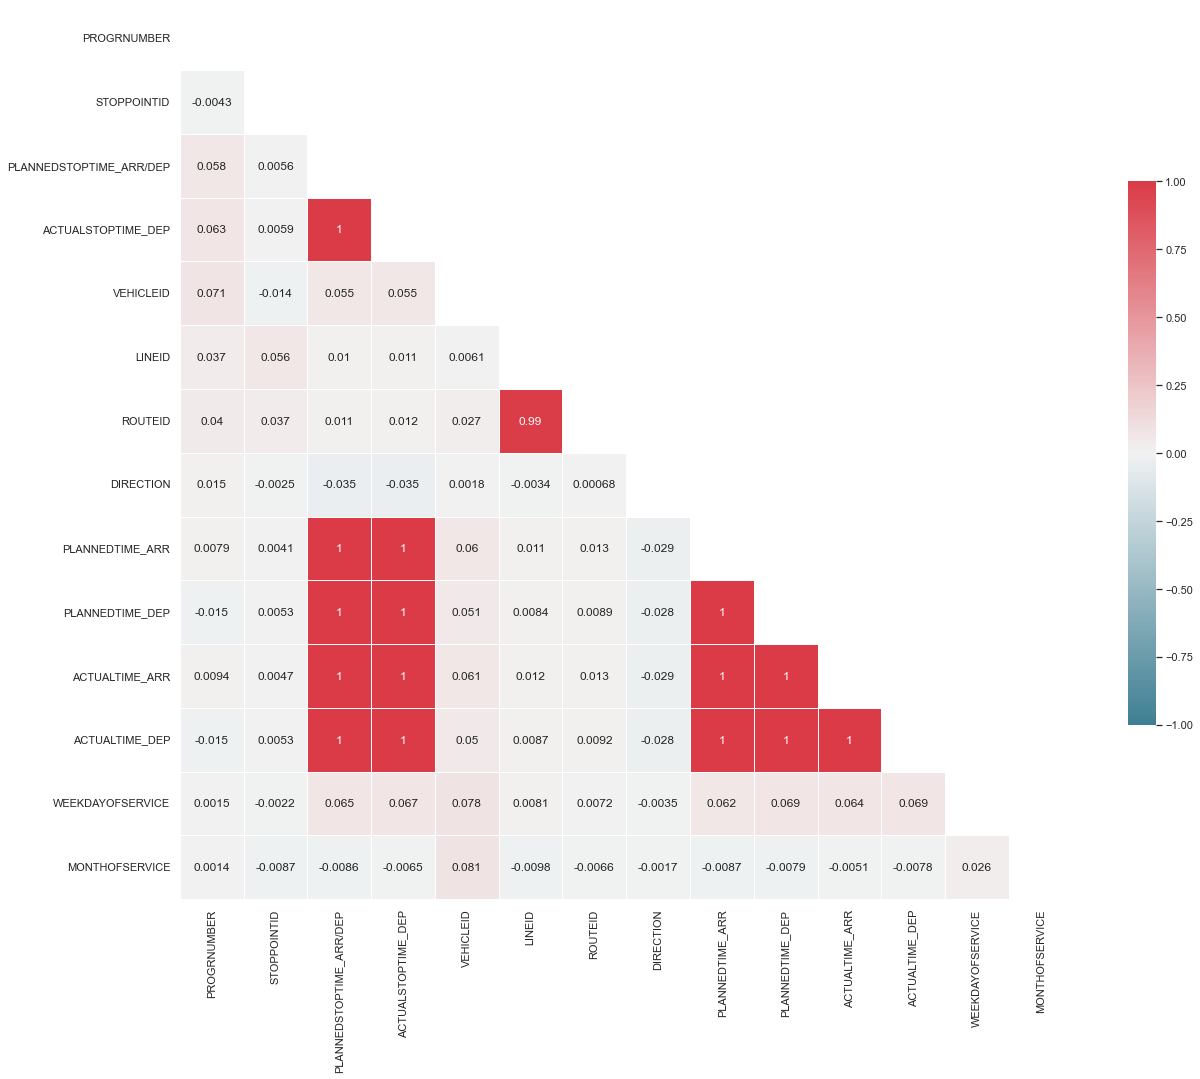

In [29]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

df_temp = X
# for column in df_temp:
    
df_temp['LINEID'] = df_temp['LINEID'].cat.codes
df_temp['ROUTEID'] = df_temp['ROUTEID'].cat.codes
df_temp['DIRECTION'] = df_temp['DIRECTION'].cat.codes

    # create temp df to merge column and target
df_temp['LINEID'] = df_temp['LINEID'].astype('int64')
df_temp['ROUTEID'] = df_temp['ROUTEID'].astype('int64')
df_temp['DIRECTION'] = df_temp['DIRECTION'].astype('int64')

    # store correlation in variable
# Calculate correlation of all pairs of continuous features
corr = df_temp.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap = True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask = mask, cmap = cmap, vmax = 1, vmin = -1,
            square = True, xticklabels = True, yticklabels = True,
            linewidths = .5, cbar_kws = {"shrink": .5}, ax = ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

We can see high correlation between:
- ACTUALSTOPTIME_DEP and PLANNEDSTOPTIME_ARR/DEP

- LINEID and ROUTEID

- PLANNEDTIME_ARR and PLANNEDSTOPTIME_ARR/DEP
- PLANNEDTIME_ARR and ACTUALSTOPTIME_DEP

- PLANNEDTIME_DEP and PLANNEDSTOPTIME_ARR/DEP
- PLANNEDTIME_DEP and ACTUALSTOPTIME_DEP
- PLANNEDTIME_DEP and PLANNEDTIME_ARR

- ACTUALTIME_DEP and PLANNEDSTOPTIME_ARR/DEP
- ACTUALTIME_DEP and ACTUALSTOPTIME_DEP
- ACTUALTIME_DEP and PLANNEDTIME_ARR
- ACTUALTIME_DEP and PLANNEDTIME_DEP


We will delete PLANNEDSTOPTIME_ARR/DEP, ROUTEID, PLANNEDTIME_DEP, ACTUALSTOPTIME_DEP, PLANNEDTIME_DEP and PLANNEDTIME_ARR.

In [30]:
df = df.drop(columns = ["PLANNEDSTOPTIME_ARR/DEP"])
df = df.drop(columns = ["ROUTEID"])
df = df.drop(columns = ["PLANNEDTIME_DEP"])
df = df.drop(columns = ["ACTUALSTOPTIME_DEP"])
df = df.drop(columns = ["PLANNEDTIME_ARR"])
df = df.drop(columns = ["ACTUALTIME_ARR"])

X = df.drop(columns = ["TIMEPASSEDSINCE_DEP"])
y = df["TIMEPASSEDSINCE_DEP"]
df.head(5)

,PROGRNUMBER,STOPPOINTID,VEHICLEID,LINEID,DIRECTION,ACTUALTIME_ARR,ACTUALTIME_DEP,WEEKDAYOFSERVICE,MONTHOFSERVICE,TIMEPASSEDSINCE_DEP
0,12,119,2693211,1,1,49653,47427,0,1,585
1,13,44,2693211,1,1,49653,47427,0,1,631
2,14,7603,2693211,1,1,49653,47427,0,1,644
3,15,45,2693211,1,1,49653,47427,0,1,662
4,16,46,2693211,1,1,49653,47427,0,1,710


In [34]:
df.dtypes

PROGRNUMBER               int64
STOPPOINTID               int64
VEHICLEID                 int64
LINEID                 category
DIRECTION              category
ACTUALTIME_DEP            int64
WEEKDAYOFSERVICE          int64
MONTHOFSERVICE            int64
TIMEPASSEDSINCE_DEP       int64
dtype: object

In [35]:
categories = ['WEEKDAYOFSERVICE', 'MONTHOFSERVICE']
strings = ['LINEID', 'DIRECTION']
# numeric = ['ACTUALTIME_DEP', 'DIFFERENCE_ARR', 'DIFFERENCE_DEP', 'PLANNEDTRIP_DURATION']

for c in categories:
    df[c] = df[c].astype('category')
    
for s in strings:
    df[s] = df[s].astype('object')
# for n in numeric:
#     df[n] = df[n].astype('int64') 

# df['LINEID'] = df['LINEID'].astype('object')
df.dtypes

PROGRNUMBER               int64
STOPPOINTID               int64
VEHICLEID                 int64
LINEID                   object
DIRECTION                object
ACTUALTIME_DEP            int64
WEEKDAYOFSERVICE       category
MONTHOFSERVICE         category
TIMEPASSEDSINCE_DEP       int64
dtype: object

In [36]:
df.nunique()

PROGRNUMBER              109
STOPPOINTID             4767
VEHICLEID               1147
LINEID                   145
DIRECTION                  2
ACTUALTIME_DEP         66596
WEEKDAYOFSERVICE           7
MONTHOFSERVICE            12
TIMEPASSEDSINCE_DEP    11272
dtype: int64

- Remove VehicleID since real time data isnt available for it

In [37]:
df = df.drop('VEHICLEID', 1)

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/1731045687.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('VEHICLEID', 1)


In [38]:
df = df.drop_duplicates()

## Save and Load Dataset

In [39]:
df.to_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_All_2018_CLEANED.csv', index=None)

In [40]:
df = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_All_2018_CLEANED.csv')

#### Set up dummy features. 
This will split up each categorical feature into a number of dummy features. The data type changes to "uint8"

Set "drop_first=True" to get rid of the first column of the each dummy feature. 

In [41]:
df.head(10)

,PROGRNUMBER,STOPPOINTID,LINEID,DIRECTION,ACTUALTIME_DEP,WEEKDAYOFSERVICE,MONTHOFSERVICE,TIMEPASSEDSINCE_DEP
0,12,119,1,1,47427,0,1,585
1,13,44,1,1,47427,0,1,631
2,14,7603,1,1,47427,0,1,644
3,15,45,1,1,47427,0,1,662
4,16,46,1,1,47427,0,1,710
5,17,47,1,1,47427,0,1,744
6,18,48,1,1,47427,0,1,762
7,19,49,1,1,47427,0,1,849
8,21,52,1,1,47427,0,1,931
9,22,265,1,1,47427,0,1,1036


In [42]:
df_copy = df

In [43]:
df_copy.shape

(103408048, 8)

In [44]:
# set up dummies features
df_copy = pd.get_dummies(df_copy, columns = ['WEEKDAYOFSERVICE', 'MONTHOFSERVICE'], drop_first=True)
df_copy.dtypes

PROGRNUMBER             int64
STOPPOINTID             int64
LINEID                 object
DIRECTION               int64
ACTUALTIME_DEP          int64
TIMEPASSEDSINCE_DEP     int64
WEEKDAYOFSERVICE_1      uint8
WEEKDAYOFSERVICE_2      uint8
WEEKDAYOFSERVICE_3      uint8
WEEKDAYOFSERVICE_4      uint8
WEEKDAYOFSERVICE_5      uint8
WEEKDAYOFSERVICE_6      uint8
MONTHOFSERVICE_2        uint8
MONTHOFSERVICE_3        uint8
MONTHOFSERVICE_4        uint8
MONTHOFSERVICE_5        uint8
MONTHOFSERVICE_6        uint8
MONTHOFSERVICE_7        uint8
MONTHOFSERVICE_8        uint8
MONTHOFSERVICE_9        uint8
MONTHOFSERVICE_10       uint8
MONTHOFSERVICE_11       uint8
MONTHOFSERVICE_12       uint8
dtype: object

In [45]:
df_copy.shape

(103408048, 23)

In [46]:
df_copy.head(5)

,PROGRNUMBER,STOPPOINTID,LINEID,DIRECTION,ACTUALTIME_DEP,TIMEPASSEDSINCE_DEP,WEEKDAYOFSERVICE_1,WEEKDAYOFSERVICE_2,WEEKDAYOFSERVICE_3,WEEKDAYOFSERVICE_4,...,MONTHOFSERVICE_3,MONTHOFSERVICE_4,MONTHOFSERVICE_5,MONTHOFSERVICE_6,MONTHOFSERVICE_7,MONTHOFSERVICE_8,MONTHOFSERVICE_9,MONTHOFSERVICE_10,MONTHOFSERVICE_11,MONTHOFSERVICE_12
0,12,119,1,1,47427,585,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13,44,1,1,47427,631,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,7603,1,1,47427,644,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,45,1,1,47427,662,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16,46,1,1,47427,710,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
df_copy = df_copy.drop_duplicates()

In [11]:
# reindex rows
df_copy.reset_index(drop=True, inplace=True)

## Save and Load Dataset

In [48]:
# save cleaned data as new csv
df_copy.to_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_All_2018_CLEANED_WITHDUMMIES.csv', index=None)

In [49]:
df = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_All_2018_CLEANED_WITHDUMMIES.csv')

/Users/danhowes1/opt/anaconda3/envs/comp47350py38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.dtypes

PROGRNUMBER             int64
STOPPOINTID             int64
LINEID                 object
DIRECTION               int64
ACTUALTIME_DEP          int64
TIMEPASSEDSINCE_DEP     int64
WEEKDAYOFSERVICE_1      int64
WEEKDAYOFSERVICE_2      int64
WEEKDAYOFSERVICE_3      int64
WEEKDAYOFSERVICE_4      int64
WEEKDAYOFSERVICE_5      int64
WEEKDAYOFSERVICE_6      int64
MONTHOFSERVICE_2        int64
MONTHOFSERVICE_3        int64
MONTHOFSERVICE_4        int64
MONTHOFSERVICE_5        int64
MONTHOFSERVICE_6        int64
MONTHOFSERVICE_7        int64
MONTHOFSERVICE_8        int64
MONTHOFSERVICE_9        int64
MONTHOFSERVICE_10       int64
MONTHOFSERVICE_11       int64
MONTHOFSERVICE_12       int64
dtype: object

### Check Old Routes vs Current Routes

In [50]:
# load current routes
df_routes = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/routes_2022.csv')
df_routes.head(5)

,route_id,agency_id,route_short_name,route_type
0,60-1-b12-1,978,1,3
1,60-11-b12-1,978,11,3
2,60-116-b12-1,978,116,3
3,60-118-b12-1,978,118,3
4,60-120-b12-1,978,120,3


In [51]:
# check old routes vs new routes
oldRoutes = list(map(str, df['LINEID'].unique()))
newRoutes = list(map(str, df_routes['route_short_name'].unique()))

currentRoutes = []
cancelledRoutes = []

for r in oldRoutes:
    if r not in newRoutes:
        cancelledRoutes += [r]
    else:
        currentRoutes += [r]

for n in newRoutes:
    if n not in oldRoutes:
        currentRoutes += [n]

print(cancelledRoutes)

['17A', '67', '66', '104', '75', '102', '33B', '25', '17', '18', '238', '270', '63', '76', '66A', '31', '32', '31A', '25B', '25A', '29A', '220', '33A', '45A', '59', '16C', '184', '185', '66B', '31B', '66X', '111', '236', '239', '76A', '67X', '42D', '14C', '25D', '70D', '41A', '51X', '114', '25X', '31D', '161', '68X', '104', '114']


### Setting up the train/test split
- Based on LINEID and DIRECTION

In [52]:
# use 46A data subset as a test example for model 
df_LINEID_46A = df[(df['LINEID'] == '46A') & (df['DIRECTION'] == 1)] #& (df_copy['STOPPOINTID'] == 406)] # 
# df_LINEID_11.reset_index(drop=True, inplace=True)
df_LINEID_46A

,PROGRNUMBER,STOPPOINTID,LINEID,DIRECTION,ACTUALTIME_DEP,TIMEPASSEDSINCE_DEP,WEEKDAYOFSERVICE_1,WEEKDAYOFSERVICE_2,WEEKDAYOFSERVICE_3,WEEKDAYOFSERVICE_4,...,MONTHOFSERVICE_3,MONTHOFSERVICE_4,MONTHOFSERVICE_5,MONTHOFSERVICE_6,MONTHOFSERVICE_7,MONTHOFSERVICE_8,MONTHOFSERVICE_9,MONTHOFSERVICE_10,MONTHOFSERVICE_11,MONTHOFSERVICE_12
15896,16,406,46A,1,35158,762,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15897,17,747,46A,1,35158,820,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15898,19,845,46A,1,35158,915,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15899,1,807,46A,1,35158,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15900,3,809,46A,1,35158,67,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103215362,12,819,46A,1,44964,640,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
103215363,43,2015,46A,1,44964,2746,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
103215364,13,264,46A,1,44964,695,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
103215365,25,757,46A,1,44964,1740,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
df_LINEID_46A.dtypes

PROGRNUMBER             int64
STOPPOINTID             int64
LINEID                 object
DIRECTION               int64
ACTUALTIME_DEP          int64
TIMEPASSEDSINCE_DEP     int64
WEEKDAYOFSERVICE_1      int64
WEEKDAYOFSERVICE_2      int64
WEEKDAYOFSERVICE_3      int64
WEEKDAYOFSERVICE_4      int64
WEEKDAYOFSERVICE_5      int64
WEEKDAYOFSERVICE_6      int64
MONTHOFSERVICE_2        int64
MONTHOFSERVICE_3        int64
MONTHOFSERVICE_4        int64
MONTHOFSERVICE_5        int64
MONTHOFSERVICE_6        int64
MONTHOFSERVICE_7        int64
MONTHOFSERVICE_8        int64
MONTHOFSERVICE_9        int64
MONTHOFSERVICE_10       int64
MONTHOFSERVICE_11       int64
MONTHOFSERVICE_12       int64
dtype: object

In [53]:
# y is the target
y = df_LINEID_46A["TIMEPASSEDSINCE_DEP"]
# X is everything else
X = df_LINEID_46A.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_LINEID_46A.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/1381104876.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_LINEID_46A.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)


original range is:  2032829
training range (70%):	 rows 0 to 1422980
test range (30%): 	 rows 1422980 to 2032829


In [54]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,PROGRNUMBER,STOPPOINTID,ACTUALTIME_DEP,WEEKDAYOFSERVICE_1,WEEKDAYOFSERVICE_2,WEEKDAYOFSERVICE_3,WEEKDAYOFSERVICE_4,WEEKDAYOFSERVICE_5,WEEKDAYOFSERVICE_6,MONTHOFSERVICE_2,MONTHOFSERVICE_3,MONTHOFSERVICE_4,MONTHOFSERVICE_5,MONTHOFSERVICE_6,MONTHOFSERVICE_7,MONTHOFSERVICE_8,MONTHOFSERVICE_9,MONTHOFSERVICE_10,MONTHOFSERVICE_11,MONTHOFSERVICE_12
0,37,7353,48945,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,12,819,59777,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,33,2008,65099,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,23,2795,37864,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,29,761,30007,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0


## Random Forest

In [55]:
# Train RF with 100 trees
rfc = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestRegressor(oob_score=True, random_state=1)

In [56]:
# Compute the importance of each feature based on the trained random forest regressor
# RF finds different feature importance than the single decision tree
# A downside is that we cannot interpret the RF with 100 trees as we could by looking at a single decision tree
# So this table is what we can use to interpret the trained model
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
feature_importance.sort_values('importance', ascending=False).head(10)

,feature,importance
0,PROGRNUMBER,0.863783
2,ACTUALTIME_DEP,0.098768
8,WEEKDAYOFSERVICE_6,0.007467
7,WEEKDAYOFSERVICE_5,0.005938
1,STOPPOINTID,0.004197
14,MONTHOFSERVICE_7,0.001695
6,WEEKDAYOFSERVICE_4,0.001612
19,MONTHOFSERVICE_12,0.001449
10,MONTHOFSERVICE_3,0.001407
5,WEEKDAYOFSERVICE_3,0.001393


In [57]:
forest_train_predictions = rfc.predict(X_train)
print("Actual vs predicted on training:\n", pd.concat([y_train, pd.DataFrame(forest_train_predictions, columns=['Predicted'], index=y_train.index)], axis=1).head(10))

Actual vs predicted on training:
    TIMEPASSEDSINCE_DEP  Predicted
0                 3140    3107.19
1                 1776    1426.65
2                 2923    2976.22
3                 1975    1973.47
4                 1935    1904.32
5                 5120    4950.25
6                 2707    2671.25
7                 3511    3160.97
8                  212     245.22
9                 2039    2155.16


In [58]:
print('\n==============================================================================')
print("MAE: ", metrics.mean_absolute_error(y_train, rfc.predict(X_train)))
print("RMSE: ", metrics.mean_squared_error(y_train, rfc.predict(X_train))**0.5)
print("R2: ", metrics.r2_score(y_train, rfc.predict(X_train)))


MAE:  65.41809881515269
RMSE:  99.95170834316788
R2:  0.9950174420894486


### Evaluate the model using the hold-out (30% examples) test set


In [59]:
print("\nPredictions with random forest regression: \n")
actual_vs_predicted_randomForest = pd.concat([y_test, pd.DataFrame(rfc.predict(X_test), columns=['Predicted'])], axis=1)
print(actual_vs_predicted_randomForest.head(10))


Predictions with random forest regression: 

   TIMEPASSEDSINCE_DEP    Predicted
0                  597   846.360000
1                  666   731.710000
2                 2374  2316.200000
3                 3421  3471.950000
4                 3592  3499.010000
5                 1489  1937.140000
6                 4783  4657.840000
7                 3338  3443.758667
8                 4581  4469.060000
9                 1081   969.760000


In [60]:
print('\n==============================================================================')
print("MAE: ", metrics.mean_absolute_error(y_test, rfc.predict(X_test)))
print("RMSE: ", metrics.mean_squared_error(y_test, rfc.predict(X_test))**0.5)
print("R2: ", metrics.r2_score(y_test, rfc.predict(X_test)))


MAE:  174.95253103890192
RMSE:  262.32672631431547
R2:  0.9655750913226929


### Cross validation


In [61]:
def cross_val_RandomForest(X, y, cv=3, scoring='MAE', depth=None, estimators=100):
    """Functions to carry out cross validation on the random forest regression model
    Default number of validations is 3. The random state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        rfcCross = RandomForestRegressor(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth).fit(X_train, y_train)
        # threshold
        forest_predictions = rfcCross.predict(X_test)
        # calc score
        if scoring=='MAE':
            score = metrics.mean_absolute_error(y_test, forest_predictions)
        elif scoring=='RMSE':
            score = metrics.mean_squared_error(y_test, forest_predictions)**0.5
        elif scoring=='R2':
            score = metrics.r2_score(y_test, forest_predictions)

        # append to results
        results.append(score)
    return results

In [62]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['MAE','RMSE','R2']

    for metric in test_metrics:
        # generate test results
        result = cross_val_RandomForest(X, y, cv=10, scoring=metric, depth=depth, estimators=estimators)
        length = len(result)
        # store result in dict
        RandomForestResults[metric] = sum(result)/length
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

In [63]:
rForestDF = cross_val_RandomForest_DF(X,y, 3)
print(f"Mean results from 10 fold cross validation are:")
rForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
MAE,395.099067
RMSE,537.479760
R2,0.855747


In [64]:
rfc.oob_score_

0.9650495920074172

## Pickling

In [66]:
df.head(5)

,PROGRNUMBER,STOPPOINTID,LINEID,DIRECTION,ACTUALTIME_DEP,TIMEPASSEDSINCE_DEP,WEEKDAYOFSERVICE_1,WEEKDAYOFSERVICE_2,WEEKDAYOFSERVICE_3,WEEKDAYOFSERVICE_4,...,MONTHOFSERVICE_3,MONTHOFSERVICE_4,MONTHOFSERVICE_5,MONTHOFSERVICE_6,MONTHOFSERVICE_7,MONTHOFSERVICE_8,MONTHOFSERVICE_9,MONTHOFSERVICE_10,MONTHOFSERVICE_11,MONTHOFSERVICE_12
0,12,119,1,1,47427,585,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,13,44,1,1,47427,631,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,7603,1,1,47427,644,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,45,1,1,47427,662,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16,46,1,1,47427,710,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# Route_list = list(df['LINEID'].unique())
model = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
errors = []

for route in currentRoutes:

    try:
        file_name = route + "_d1_model.pkl"
        file_exists = exists('/Users/danhowes1/Desktop/UCD/Research_Project/' + file_name)
        if file_exists: 
            pass
        else:
            df_new = df[(df['LINEID']== route) & (df['DIRECTION']== 1)]

            X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
            y = df_new['TIMEPASSEDSINCE_DEP']

            x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

            # Train the model
            model.fit(x_train, y_train)

            with open(file_name, 'wb') as handle: 
                joblib.dump(model, handle, pickle.HIGHEST_PROTOCOL)
    except:
        errors += [file_name]
        print(file_name)

for route in currentRoutes:
    try:
        file_name = route + "_d2_model.pkl"
        file_exists = exists('/Users/danhowes1/Desktop/UCD/Research_Project/' + file_name)
        if file_exists: 
            pass
        else:
            df_new = df[(df['LINEID']== route) & (df['DIRECTION']== 2)]

            X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
            y = df_new['TIMEPASSEDSINCE_DEP']

            x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

            # Train the model
            model.fit(x_train, y_train)

            with open(file_name, 'wb') as handle: 
                joblib.dump(model, handle, pickle.HIGHEST_PROTOCOL)
    except:
        errors += [file_name]
        print(file_name)


/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame

46E_d1_model.pkl


/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame

77X_d1_model.pkl
118_d1_model.pkl


/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame

155_d1_model.pkl
52_d1_model.pkl
6_d1_model.pkl
H1_d1_model.pkl
H2_d1_model.pkl
H3_d1_model.pkl
C1_d1_model.pkl
C2_d1_model.pkl
C3_d1_model.pkl
C4_d1_model.pkl
C5_d1_model.pkl
C6_d1_model.pkl
P29_d1_model.pkl
L53_d1_model.pkl
L54_d1_model.pkl
L58_d1_model.pkl
L59_d1_model.pkl
X25_d1_model.pkl
X26_d1_model.pkl
X27_d1_model.pkl
X28_d1_model.pkl
X30_d1_model.pkl
X31_d1_model.pkl
X32_d1_model.pkl
N4_d1_model.pkl


/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)
/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame

16D_d2_model.pkl
33E_d2_model.pkl


/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_96866/4291452185.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = df_new.drop(["TIMEPASSEDSINCE_DEP", 'LINEID', 'DIRECTION'],1)


155_d2_model.pkl
52_d2_model.pkl
6_d2_model.pkl
H1_d2_model.pkl
H2_d2_model.pkl
H3_d2_model.pkl
C1_d2_model.pkl
C2_d2_model.pkl
C3_d2_model.pkl
C4_d2_model.pkl
C5_d2_model.pkl
C6_d2_model.pkl
P29_d2_model.pkl
L53_d2_model.pkl
L54_d2_model.pkl
L58_d2_model.pkl
L59_d2_model.pkl
X25_d2_model.pkl
X26_d2_model.pkl
X27_d2_model.pkl
X28_d2_model.pkl
X30_d2_model.pkl
X31_d2_model.pkl
X32_d2_model.pkl
N4_d2_model.pkl


In [68]:
len(errors)

55

In [69]:
# check one of the errors
df[df['LINEID'] == '33E'].nunique()

PROGRNUMBER             108
STOPPOINTID             108
LINEID                    1
DIRECTION                 1
ACTUALTIME_DEP           13
TIMEPASSEDSINCE_DEP    1306
WEEKDAYOFSERVICE_1        2
WEEKDAYOFSERVICE_2        2
WEEKDAYOFSERVICE_3        2
WEEKDAYOFSERVICE_4        2
WEEKDAYOFSERVICE_5        1
WEEKDAYOFSERVICE_6        1
MONTHOFSERVICE_2          1
MONTHOFSERVICE_3          1
MONTHOFSERVICE_4          1
MONTHOFSERVICE_5          1
MONTHOFSERVICE_6          1
MONTHOFSERVICE_7          1
MONTHOFSERVICE_8          1
MONTHOFSERVICE_9          1
MONTHOFSERVICE_10         1
MONTHOFSERVICE_11         1
MONTHOFSERVICE_12         1
dtype: int64

In [8]:
df_LINEID_27B = df[(df['LINEID'] == '41D') & (df['DIRECTION'] == 2) & (df['STOPPOINTID'] == 3690)] # 
df_LINEID_27B.head(10)

,PROGRNUMBER,STOPPOINTID,LINEID,DIRECTION,ACTUALTIME_DEP,WEEKDAYOFSERVICE,MONTHOFSERVICE,TIMEPASSEDSINCE_DEP
100752376,5,3690,41D,2,32973,3,12,4492


- We can see the error is justified as there is insufficient data available to model this route.

## Open pickle files and make predictions

- First I will load the JSON file for routeShapes.

In [44]:
# open JSON file and check contents
with open('routeStops.json') as json_file:
    data = json.load(json_file)
    print(data)

{'1': {'0': {'DepTimes': {'monday': [23400, 24120, 24840, 25560, 26280, 27000, 27600, 28200, 28800, 29400, 30000, 30720, 31440, 32160, 32400, 32880, 33600, 34200, 34320, 35040, 35760, 36000, 36480, 37200, 37800, 37920, 38640, 39360, 39600, 40080, 40800, 41520, 42000, 42240, 42960, 43200, 43680, 44400, 45120, 45600, 45840, 46560, 46800, 47280, 48000, 48720, 49200, 49440, 50160, 50400, 50880, 51600, 52320, 52800, 53040, 53760, 54000, 54480, 55200, 55920, 56400, 56640, 57360, 57600, 58080, 58800, 59520, 60000, 60240, 60960, 61200, 61680, 62400, 63120, 63600, 63840, 64560, 64800, 65280, 66000, 66720, 67200, 67440, 68160, 68400, 68880, 69600, 70800, 72000, 73200, 74400, 75600, 76800, 78000, 79200, 80400, 81600, 82800, 83700, 84600], 'tuesday': [23400, 24120, 24840, 25560, 26280, 27000, 27600, 28200, 28800, 29400, 30000, 30720, 31440, 32160, 32880, 33600, 34320, 35040, 35760, 36480, 37200, 37920, 38640, 39360, 40080, 40800, 41520, 42240, 42960, 43680, 44400, 45120, 45840, 46560, 47280, 48000

- The format for the JSON file is a dictionary:
    Each routeID is a key
        Within each routeID are direction keys 0, 1
            Within each direction are DepTimes for each day of the week
            And Stops, with each stop number mapped to the sequence number of that stop on the route
- Accessing the first departure time on a monday looks like 

        data[routeID][direction]['DepTimes']['monday'][0]
    
    
- Accessing the sequence number for a stop looks like 

        data[routeID][direction]['Stops'][StopNumber][0]
    
    
- The way I was thinking of using this is when the user inputs a time they'd like the bus to arrive at, make multiple predictions using different departure times to see which will have the closest arrival time to the users specified time

In [50]:
# find where stop 44 is on route 1
data['1']['0']['Stops']['44'][0]

'13'

In [51]:
# find when the first 5 route 1 buses leave on a monday 
data['1']['0']['DepTimes']['monday'][0:5]

[23400, 24120, 24840, 25560, 26280]

In [70]:
"""
Load a pickle file and make a prediction

Prediction format is pk.predict(stopSequencNumber, stopNumber, departureTimeOfFullTrip, Monday, Tuesday, Wednesday, 
Thursday, Friday, Saturday, Feb, March, April, May, June, July, August, Sept, Oct, Nov, Dec)

"""
pk = load('46A_d1_model.pkl')
time_predict = pk.predict([[44, 2017, 44964, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

predict_list = time_predict.tolist()
predict_dict = {"timesinceDep": predict_list[0]}
result = json.dumps(predict_dict)

print(result)

{"timesinceDep": 3811.75}


/Users/danhowes1/opt/anaconda3/envs/comp47350py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [47]:
"""
Function to make a prediction for either bus arrival time at a single stop or journey duration between two stops

Args:
    route: The name of the bus route selected by the user.   A string.
    direction: The direction selected by the user, either 0 or 1.
    stopA: The stop number selected by the user.
    departureTime: The time at which the bus starts the journey from stop 1.   An integer.
    day: Day of the week selected by the user.   An integer from 0 - 6.   Sunday is 0, Saturday is 6.
    month: Month selected by the user.   An integer from 0 - 11.   January is 0, December is 11.
    stopB: Destination stop number selected by the user.   Optional.
Returns:
    An dict that maps the appropriate result with a float.
    
    The key depends on whether one or two stops are input into the function.   If a single stop is input, the function
    returns the predicted arrival time for the bus at that stop, determined by adding the departureTime with the predicted
    time since departure.
    If two stops are input, two predictions are made for the origin stop and destination stop.   The origin stop
    prediction is taken away from the destination stop prediction to get a predicted journey duration time.
"""

def busPrediction(route, direction, stopA, departureTime, day, month, stopB = None):
    
#     make sure parameters are of right type
    route = str(route)
    stopA = str(stopA)
    day = int(day)
    month = int(month)

#     call pickle file (pickle files were named wrong the file is called d1 for direction 0, and d2 for direction 1)
    pickleStopA = route + '_d' + str(direction + 1)+ '_model.pkl'
    
#     assign main parameters to an array
    busStopA = [int(data[route][str(direction)]['Stops'][stopA][0]), int(stopA), departureTime]
    
#     allocate values to dummy features based on user input
    days = [0, 0, 0, 0, 0, 0]
    months = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
    days[day - 1] = 0 if (day == 0) else 1
    months[month - 1] = 0 if (month == 0) else 1

#     add main parameters with dummy values to get full list of parameters
    paramsA = busStopA + days + months
    
#     load the pickle file
    with gzip.open(pickleStopA, 'rb') as f:
        pFile = pickle.Unpickler(f)
        pickleStop = pFile.load()
    
#     make a prediction and convert to a list
    A_predict = pickleStop.predict([paramsA])

#     check whether a second stop was entered and make a prediction for the destination stop
    if stopB != None:
        stopB = str(stopB)
        busStopB = [int(data[route][str(direction)]['Stops'][stopB][0]), int(stopB), departureTime]
        paramsB = busStopB + days + months
        A_predict = pickleStop.predict([paramsA])
        
        B_predict = pickleStop.predict([paramsB])
        
#         tailor results based on number of stops entered 
        predict_dict = {"JourneyDuration":  B_predict[0] - A_predict[0]}
    else:
        predict_dict = {"ArrivalTime": A_predict[0]  + departureTime}
    
#     result = json.dumps(predict_dict)
    
    return predict_dict


In [48]:
# make a prediction for route 1, direction 0, stop 226, bus departure time 44964, on a Tuesday in November
busPrediction('1', 0, 226, 44964, 2, 10)

/Users/danhowes1/opt/anaconda3/envs/comp47350py38/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


'{"ArrivalTime": 44964.0}'